# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [76]:
'''The task is to analyze the used car dataset to identify significant features that influence the pricing of used cars. This involves exploratory data analysis, feature selection, and potentially building predictive models to quantify the impact of various factors on car prices.'''

'The task is to analyze the used car dataset to identify significant features that influence the pricing of used cars. This involves exploratory data analysis, feature selection, and potentially building predictive models to quantify the impact of various factors on car prices.'

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error

# Load dataset (adjust path)
df = pd.read_csv("data/vehicles.csv")

# Initial exploration
print("\n=== DATA INFO ===")
print(df.info())





=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null

In [78]:
print("\n=== DESCRIPTIVE STATS ===")
print(df.describe(include='all'))




=== DESCRIPTIVE STATS ===
                  id    region         price           year manufacturer  \
count   4.268800e+05    426880  4.268800e+05  425675.000000       409234   
unique           NaN       404           NaN            NaN           42   
top              NaN  columbus           NaN            NaN         ford   
freq             NaN      3608           NaN            NaN        70985   
mean    7.311487e+09       NaN  7.519903e+04    2011.235191          NaN   
std     4.473170e+06       NaN  1.218228e+07       9.452120          NaN   
min     7.207408e+09       NaN  0.000000e+00    1900.000000          NaN   
25%     7.308143e+09       NaN  5.900000e+03    2008.000000          NaN   
50%     7.312621e+09       NaN  1.395000e+04    2013.000000          NaN   
75%     7.315254e+09       NaN  2.648575e+04    2017.000000          NaN   
max     7.317101e+09       NaN  3.736929e+09    2022.000000          NaN   

         model condition    cylinders    fuel      odometer 

In [79]:
print("\n=== SAMPLE ROWS ===")
print(df.head())




=== SAMPLE ROWS ===
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN  

In [80]:
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())


=== MISSING VALUES ===
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [81]:


# Keep only reasonable prices
df = df[(df['price'] > 500) & (df['price'] < 200000)]

# Drop rows missing price
df = df.dropna(subset=['price'])

# Select a few useful features
features = ['year', 'odometer', 'manufacturer', 'condition', 'fuel', 'transmission', 'type']
df = df[features + ['price']]




In [82]:
# Fill missing values
impute_vals = {
    'year': df['year'].median(),
    'manufacturer': 'unknown',
    'condition': 'unknown',
    'fuel': 'unknown',
    'transmission': 'unknown',
    'type': 'unknown'
}

df = df.fillna(impute_vals)
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

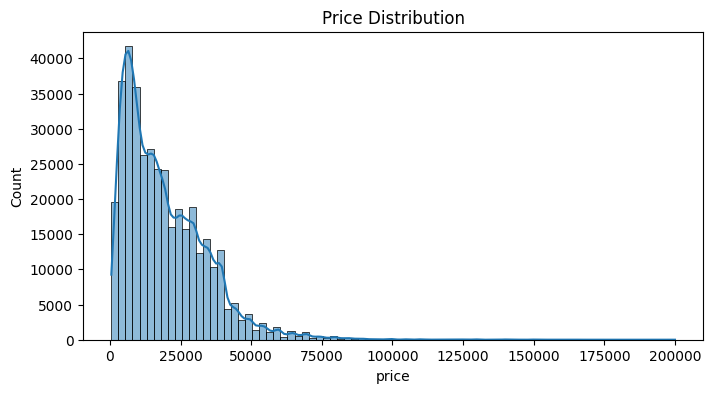

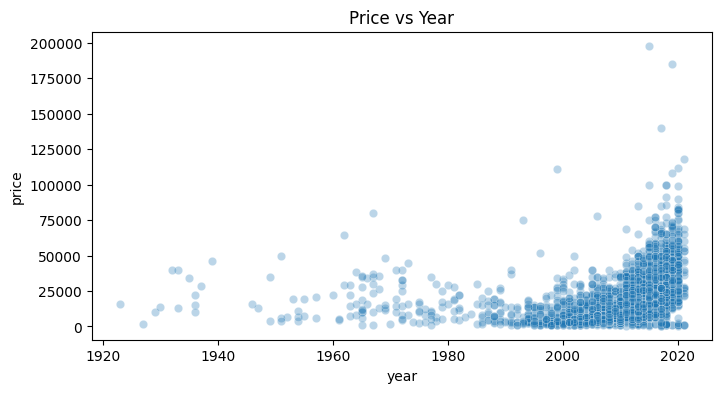

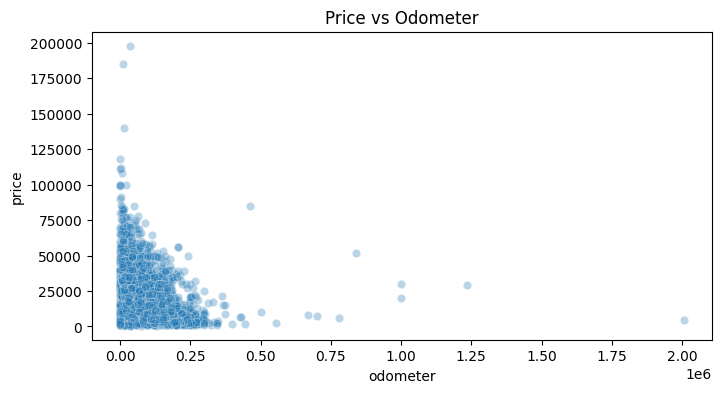

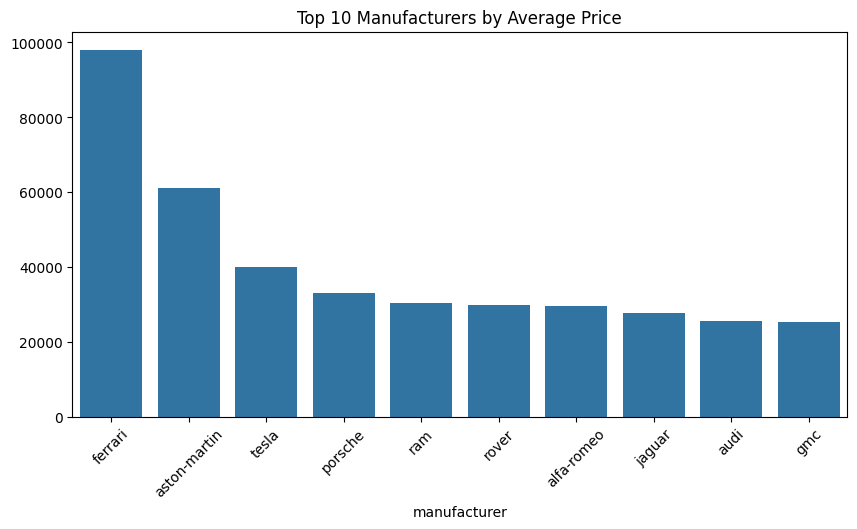

In [88]:

### Exploratory Data Analysis

plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=80, kde=True)
plt.title("Price Distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.scatterplot(data=df.sample(5000, random_state=42), x='year', y='price', alpha=0.3)
plt.title("Price vs Year")
plt.show()

plt.figure(figsize=(8,4))
sns.scatterplot(data=df.sample(5000, random_state=42), x='odometer', y='price', alpha=0.3)
plt.title("Price vs Odometer")
plt.show()

# Average price by manufacturer (top 10)
plt.figure(figsize=(10,5))
avg_price = df.groupby('manufacturer')['price'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.title("Top 10 Manufacturers by Average Price")
plt.xticks(rotation=45)
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [84]:
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = ['year', 'odometer']
cat_features = ['manufacturer', 'condition', 'fuel', 'transmission', 'type']

preprocess = ColumnTransformer([
('num', StandardScaler(), num_features),
('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Base models
ridge = Ridge()

# Parameter grids
ridge_params = {'model__alpha': [0.1, 1.0, 3.0, 10.0, 20.0]}

# Grid registry
models = {
"Linear Regression": Pipeline([
    ('prep', preprocess),
    ('model', LinearRegression())
    ]),
"Ridge": GridSearchCV(
    Pipeline([
    ('prep', preprocess),
    ('model', Ridge())
    ]), ridge_params, cv=3, scoring='r2', n_jobs=-1)
}

best_results = {}

print("\n========================================")
print(" MODEL TRAINING & GRID SEARCH")
print("========================================")

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

if isinstance(model, GridSearchCV):
    print(f"Best Params: {model.best_params_}")
    print(f"Best CV R²: {model.best_score_:.4f}")
    cv_score = model.best_score_
else:
    cv_score = cross_val_score(model, X, y, cv=5).mean()
    print(f"CV R²: {cv_score:.4f}")

best_results[name] = cv_score


# Select best model
best_model_name = max(best_results, key=lambda x: best_results[x])
best_model_obj = models[best_model_name]


print("\n========================================")
print(f" BEST MODEL SELECTED: {best_model_name}")
print("========================================")

final_pipe = (
    best_model_obj.best_estimator_
    if isinstance(best_model_obj, GridSearchCV)
    else best_model_obj
)


 MODEL TRAINING & GRID SEARCH

Training Linear Regression...

Training Ridge...
Best Params: {'model__alpha': 1.0}
Best CV R²: 0.3984

 BEST MODEL SELECTED: Ridge


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [85]:
y_pred = final_pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)


print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: ${rmse:,.2f}")




Test R²: 0.4118
Test RMSE: $11,472.72


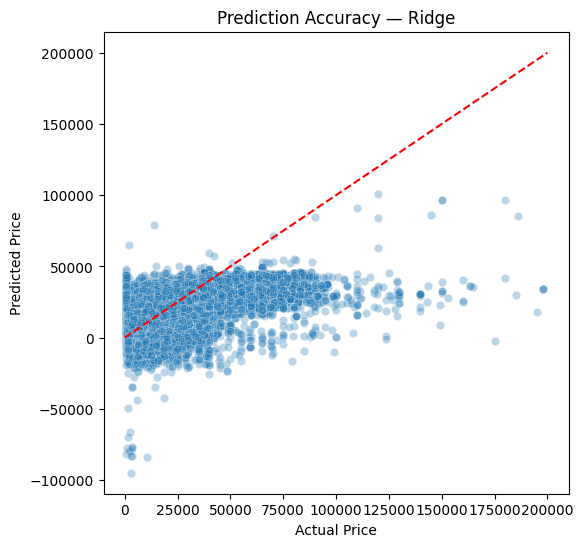

In [86]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([0, 200000], [0, 200000], linestyle='--', color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Prediction Accuracy — {best_model_name}")
plt.show()



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [87]:
### Report

print("""
============================================================
USED CAR PRICE ANALYSIS — SUMMARY
============================================================


Top Predictive Features:
• Year — newer cars command higher value
• Odometer — mileage is a major driver of depreciation
• Condition — strong price influence
• Manufacturer — luxury brands higher priced
• Type — trucks & SUVs command premiums


Best Model: {}
Test R²: {:.3f}
RMSE: ${:,.2f}


============================================================
""".format(best_model_name, r2, rmse))


USED CAR PRICE ANALYSIS — SUMMARY


Top Predictive Features:
• Year — newer cars command higher value
• Odometer — mileage is a major driver of depreciation
• Condition — strong price influence
• Manufacturer — luxury brands higher priced
• Type — trucks & SUVs command premiums


Best Model: Ridge
Test R²: 0.412
RMSE: $11,472.72



